### Powerplants optimization

#### 1)Import Packages

In [1]:
import pypsa
import pandapower as pp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import warnings
import subprocess
from shapely.errors import ShapelyDeprecationWarning
import logging

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("pypsa.pf").setLevel(logging.WARNING)
plt.rc("figure", figsize=(10, 8))

#### 2)Create a network and set Snapshots

In [2]:
# Create a new PyPSA network
network = pypsa.Network()
network.set_snapshots(range(8760))  # Solve for a year 365*24

#### 3)Add Buses

In [3]:
# Define the buses (electricity demand)
network.add("Bus", "electricity_bus", carrier="electricity")

In [4]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity_bus,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,


#### 4)Add generators

In [5]:
# Read excel file which contains Non renewable generators data
generators=pd.read_excel('data.xlsx',sheet_name='generators')

In [6]:
generators.head()

,generator,p_nom,p_nom_max,bus,p_nom_extendable,marginal_cost,lifetime,efficiency,start_up_cost,shut_down_cost,min_up_time,min_down_time,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
0,Coal,60,100,electricity_bus,True,35,25,0.3,50,NaN,4,3,0.54,0.75,NaN,NaN
1,Gas,40,120,electricity_bus,True,40,30,0.4,24,NaN,2,2,0.75,0.75,NaN,NaN


In [7]:
generators_sample=generators[['generator','p_nom']]

In [8]:
generators_sample

,generator,p_nom
0,Coal,60
1,Gas,40


In [9]:
network.madd(
    "Generator",
    generators.generator,
    bus='electricity_bus',
    carrier=list(generators.generator),
    p_nom=list(generators.p_nom),
    p_nom_max=list(generators.p_nom_max),  # MW
    p_nom_extendable=list(generators.p_nom_extendable),
    marginal_cost=list(generators.marginal_cost),
)
network.generators

,bus,carrier,p_nom,p_nom_max,p_nom_extendable,marginal_cost,control,type,p_nom_mod,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,sign,marginal_cost_quadratic,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Coal,electricity_bus,Coal,60.0,100.0,True,35.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Gas,electricity_bus,Gas,40.0,120.0,True,40.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [10]:
# Read excel file which contains Renewable plants data
generators_renew=pd.read_excel('data.xlsx',sheet_name='generators_renew')
PV_timeseries=pd.read_excel('data.xlsx',sheet_name='PV_timeseries')
wind_timeseries=pd.read_excel('data.xlsx',sheet_name='wind_timeseries')

In [11]:
PV_timeseries.head()

,Unnamed: 0,solar_PV_kW,solar_PV_MW
0,2020-01-01 00:00:00,0.0,0.0
1,2020-01-01 01:00:00,0.0,0.0
2,2020-01-01 02:00:00,0.0,0.0
3,2020-01-01 03:00:00,0.0,0.0
4,2020-01-01 04:00:00,0.0,0.0


In [12]:
# Add generators Renewable
network.madd(
    "Generator",
    generators_renew.generator,
    bus='electricity_bus',
    carrier=list(generators_renew.generator),
    p_nom=list(generators_renew.p_nom),
    #p_max_pu=list(PV_timeseries.solar_PV_MW),
    p_nom_max=list(generators_renew.p_nom_max),
    capital_cost=list(generators_renew.capital_cost),
    marginal_cost=list(generators_renew.marginal_cost),
    efficiency=list(generators_renew.efficiency),
    p_nom_extendable=True,
    )
network.generators

,bus,carrier,p_nom,p_nom_max,p_nom_extendable,marginal_cost,control,type,p_nom_mod,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,sign,marginal_cost_quadratic,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Coal,electricity_bus,Coal,60.0,100.0,True,35.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Gas,electricity_bus,Gas,40.0,120.0,True,40.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,0.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solarPV_rooftop,electricity_bus,solarPV_rooftop,200.0,300.0,True,0.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,525000.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solarPV_utility,electricity_bus,solarPV_utility,20.0,30.0,True,0.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,425000.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind_offshore,electricity_bus,wind_offshore,60.0,100.0,True,0.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,1600000.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
wind_onshore,electricity_bus,wind_onshore,20.0,100.0,True,0.0,PQ,,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,inf,1040000.0,1.0,False,0.0,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [13]:
'''
In PyPSA (Python for Power System Analysis), network.generators_t is a DataFrame 
that stores time series data related to the generators in your power system network. 
Specifically, it contains information about how the generators operate over time, 
including their power output and other attributes.

'''
network.generators_t.p_max_pu["solar_pv_rooftop","solar_pv_utility"] = list(PV_timeseries.solar_PV_MW)
network.generators_t.p_max_pu["wind_offshore","wind_onshore"] = list(wind_timeseries.wind_power_MW)


In [48]:
network.generators_t.p_max_pu

Generator,"(solar_pv_rooftop, solar_pv_utility)",wind_offshore
snapshot,,
0,0.0,0.117738
1,0.0,0.174354
2,0.0,0.228422
3,0.0,0.266398
4,0.0,0.281166
5,0.0,0.269151
6,1.5,0.243012
7,34.7,0.218581
8,71.9,0.181663


#### 5)Add Carriers and CO2 emission constraints

In [14]:
co2_emissions=pd.read_excel('data.xlsx',sheet_name='co2_emissions')

In [15]:
# Add carriers with emissions associated with it
network.madd(
    "Carrier",
    network.generators.carrier.to_list(),
    nice_name=network.generators.carrier.to_list(),
    color=["dodgerblue", "yellowgreen", "gold", "magenta","indianred","aquablue"],
    co2_emissions=list(co2_emissions.co2_emissions)
)

Index(['Coal', 'Gas', 'solarPV_rooftop', 'solarPV_utility', 'wind_offshore',
       'wind_onshore'],
      dtype='object')

In [16]:
network.add(
    "GlobalConstraint",
    "emission_limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=5000, #Maximum limit of emissions in a year tonnes/MWh
)

#### 6)Add demand

In [17]:
# Read demand data from Excel file
demand_el=pd.read_excel('data.xlsx',sheet_name='load')
demand_el.load_MW_2020.head()

0    18
1    17
2    16
3    16
4    20
Name: load_MW_2020, dtype: int64

In [18]:
demand_el.load_MW_2020.sum()

336175

In [19]:
# Add demand time series
network.add(
    "Load",
    "demand",
    bus="electricity_bus",
    p_set=demand_el.load_MW_2020,
)

<Axes: xlabel='snapshot', ylabel='MW'>

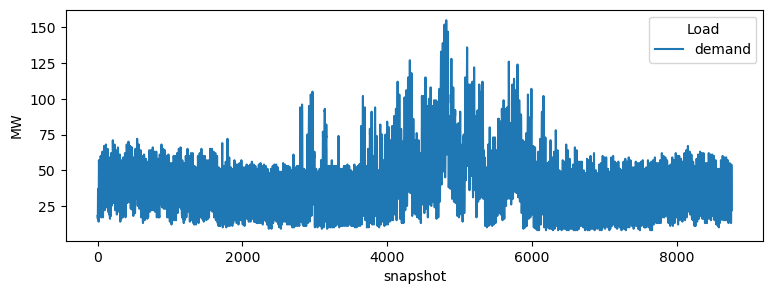

In [20]:
network.loads_t.p_set.plot(figsize=(9,3), ylabel="MW")

#### 7)Solve the Network

In [24]:
# Optimize the network to minimize the total cost
network.optimize(solver_name="highs")

Index([('solar_pv_rooftop', 'solar_pv_utility'), ('wind_offshore', 'wind_onshore')], dtype='object', name='Generator')
Index([('solar_pv_rooftop', 'solar_pv_utility'), ('wind_offshore', 'wind_onshore')], dtype='object', name='Generator')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 23.95it/s]
INFO:linopy.io: Writing time: 0.84s
INFO:linopy.solvers:Log file at C:\Users\par19744\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52567 primals, 113893 duals
Objective: -1.93e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [26]:
network.statistics()

Optimal Capacity  Installed Capacity  \
Generator Coal                   100.000000                60.0   
          Gas                    120.000000                40.0   
          solarPV_rooftop         45.174184               200.0   
          solarPV_utility         30.000000                20.0   
          wind_offshore            0.000000                60.0   
          wind_onshore             0.000000                20.0   
Load      -                        0.000000                 0.0   

                           Capacity Factor       Dispatch Transmission  \
Generator Coal                    0.000000       0.000000          0.0   
          Gas                     0.011891   12500.000000          0.0   
          solarPV_rooftop         0.479286  189665.796267          0.0   
          solarPV_utility         0.509928  134009.203733          0.0   
          wind_offshore                NaN       0.000000          0.0   
          wind_onshore                 NaN       0.000000          0.0   
Load      -                            NaN -336175.000000          0.0   

                           Withdrawal         Supply  Curtailment  \
Generator Coal                    0.0       0.000000          0.0   
          Gas                     0.0   12500.000000          0.0   
          solarPV_rooftop         0.0  189665.796267          0.0   
          solarPV_utility         0.0  134009.203733          0.0   
          wind_offshore           0.0       0.000000          0.0   
          wind_onshore            0.0       0.000000          0.0   
Load      -                  336175.0       0.000000          0.0   

                           Capital Expenditure  Operational Expenditure  \
Generator Coal                    0.000000e+00                      0.0   
          Gas                     0.000000e+00                 500000.0   
          solarPV_rooftop         2.371645e+07                      0.0   
          solarPV_utility         1.275000e+07                      0.0   
          wind_offshore           0.000000e+00                      0.0   
          wind_onshore            0.000000e+00                      0.0   
Load      -                       0.000000e+00                      0.0   

                                Revenue  Market Value  
Generator Coal             0.000000e+00      0.000000  
          Gas              1.020607e+07    816.485226  
          solarPV_rooftop  2.371645e+07    125.043349  
          solarPV_utility  1.575000e+07    117.529241  
          wind_offshore    0.000000e+00      0.000000  
          wind_onshore     0.000000e+00      0.000000  
Load      -               -4.967251e+07           NaN

#### 8)Results Visualization

In [25]:
# Print the results
print(f"Total Optimized Cost of Electricity Generation: {network.objective} €")
solution=network.generators_t.p
solution.to_csv("solution.csv")
solution.head(5)

Total Optimized Cost of Electricity Generation: -193333553.65474328 €


Generator,Coal,Gas,solarPV_rooftop,solarPV_utility,wind_offshore,wind_onshore
snapshot,,,,,,
0,-0.0,-0.0,18.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,17.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,16.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,16.0,-0.0,-0.0
4,-0.0,-0.0,20.0,-0.0,-0.0,-0.0


<Axes: xlabel='snapshot', ylabel='Generation MW'>

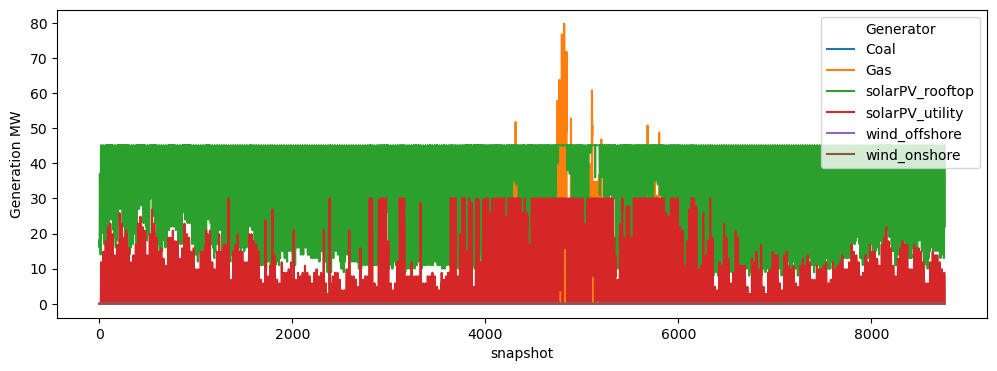

In [ ]:
network.generators_t.p.plot(figsize=(12,4), ylabel="Generation MW")

In [ ]:
solution['Coal'].idxmax()

0

In [ ]:
# Individual emissions
emissions_ind = (network.generators_t.p* network.generators.carrier.map(network.carriers.co2_emissions))

# Total emissions
print(f"Total Emissions: {emissions_ind.sum()} tons")
print(f"Total Emissions: {emissions_ind.sum().sum()} tons")

Total Emissions: Generator
Coal                  0.000000
Gas                4999.997424
solarPV_rooftop       0.000000
solarPV_utility       0.000000
wind_offshore         0.000000
wind_onshore          0.000000
dtype: float64 tons
Total Emissions: 4999.997424 tons


In [ ]:
network.generators_t.p.sum()

Generator
Coal                    0.000000
Gas                 12499.993560
solarPV_rooftop    280497.759000
solarPV_utility     43177.271132
wind_offshore           0.000000
wind_onshore            0.000000
dtype: float64

<Axes: xlabel='Generator', ylabel='Total generation MW'>

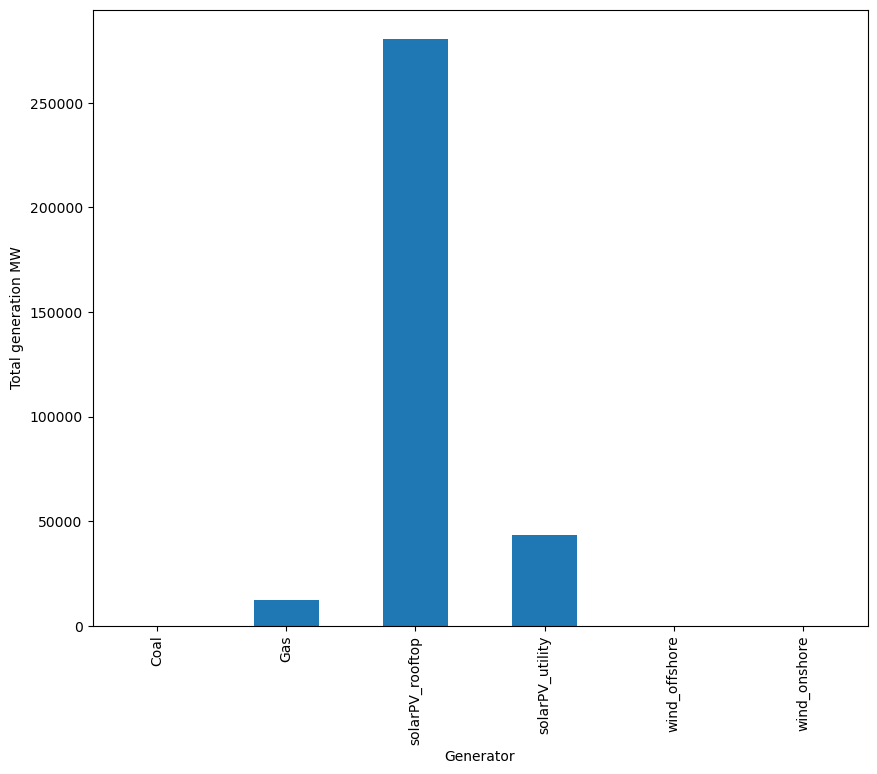

In [ ]:
network.generators_t.p.sum().plot.bar(ylabel="Total generation MW")